# Analyzing Open Source Baseball Data

This notebook has examples of several questions that can be answered using Pandas and the Lahman/Retrosheet data.

This notebook will explain how the solution is arrived at, but it will not teach Python, Pandas, Numpy, Matplotlib, and Seaborn per se.

## Preliminaries

This notebook assumes that the Lahman and Retrosheet data sets have been downloaded and wrangled using the scripts in the `../download_scripts` directory of this repo.

## MLB Data Summary

Here are the key csv files.

**Lahman**  
* Stats per Player per Year:
  * batting.csv
  * pitching.csv
  * fielding.csv
* Stats per Team per Year:
  * teams.csv -- contains team_id for both Lahman and Retrosheet
* Other
  * people.csv -- contains player_id for both Lahman and Retrosheet
  
**Retrosheet**  
* Stats per Player per Game:
  * batting.csv.gz
  * pitching.csv.gz
  * fielding.csv.gz
* Stats per Team per Game:
  * team_game.csv.gz
* Stats per Game:
  * game.csv.gz 

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import re
import statsmodels.api as sm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # increase the default dpi

In [4]:
import sys

# import data_helper.py from download_scripts directory
sys.path.append('../download_scripts')
import data_helper as dh

In [5]:
data_dir = Path('../data')
lahman_data = data_dir.joinpath('lahman/wrangled').resolve()
retrosheet_data = data_dir.joinpath('retrosheet/wrangled').resolve()

In [6]:
pd.set_option("display.max_columns", 50)

In [7]:
from IPython.display import HTML, display
def game_id_to_url(game_id):
    """Create html link from game_id to box score on Baseball-Reference.com"""
    url = 'https://www.baseball-reference.com/boxes/' + game_id[:3] + \
        '/' + game_id + '.shtml'
    display(HTML(f'<a href="{url}">{game_id}</a>'))

In [8]:
def simple_loess(x, y, df, frac=1/3, it=0):
    """Smoothes noisy data.
    
    Increase frac to get more smoothing.
    Decrease frac to get less smoothing.
    
    sns.lmplot has a loess option, but it uses poor defaults."""
    z = sm.nonparametric.lowess(df[y], df[x], frac=frac, it=it)
    return pd.DataFrame(data=z, columns=[x, y])

# Are Baseball Games Getting Longer over the Years?

In [9]:
game = dh.from_csv_with_types(retrosheet_data / 'game.csv.gz')

In [10]:
game.head(3)

,game_id,game_start_dt,game_ct,daynight_park_cd,park_id,base4_ump_id,base1_ump_id,base2_ump_id,base3_ump_id,scorer_record_id,translator_record_id,inputter_record_id,input_record_ts,method_record_cd,pitches_record_cd,game_length_minutes,game_length_innings,win_pit_id,lose_pit_id,save_pit_id,gwrbi_bat_id,game_length_outs,win_pit_name_tx,lose_pit_name_tx,save_pit_name_tx,goahead_rbi_id,goahead_rbi_name_tx,dh,attendance,temperature,wind_direction,wind_speed,field_condition,precip_type,sky_condition
0,BAL195504120,1955-04-12,0,D,BAL11,grieb901,stevj901,nappl901,ricej901,Orioles,D Lamoureaux,D Lamoureaux,1997/01/17 5:20AM,0,0,145,9,sullf101,colej101,NaN,NaN,54,Frank Sullivan,Joe Coleman,(none),throf101,Faye Throneberry,False,38085,NaN,NaN,NaN,NaN,NaN,NaN
1,BAL195504180,1955-04-18,0,N,BAL11,ricej901,grieb901,stevj901,nappl901,"yankees,orioles",Sheldon Miller,Sheldon Miller,1996/09/01 9:46PM,1,0,146,9,fordw101,moorr101,NaN,NaN,54,Whitey Ford,Ray Moore,(none),norei101,Irv Noren,False,35372,NaN,NaN,NaN,NaN,none,night
2,BAL195504220,1955-04-22,0,N,BAL11,berrc103,mckib901,flahr901,chyln901,Senators,Charles Voas,Charles Voas,1994/07/16 10:43AM,1,0,168,9,mcdem102,wilsj104,schmj101,NaN,54,Mickey McDermott,Jim Wilson,Johnny Schmitz,NaN,(none),False,18723,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# analysis is easier if there is an explict year column
game['year'] = game['game_start_dt'].dt.year

In [12]:
minutes_per_game = \
    game.groupby('year', as_index=False)['game_length_minutes'].aggregate('mean')
minutes_per_game.tail()

,year,game_length_minutes
60,2015,180.804446
61,2016,184.771005
62,2017,188.736626
63,2018,184.953928
64,2019,189.989296


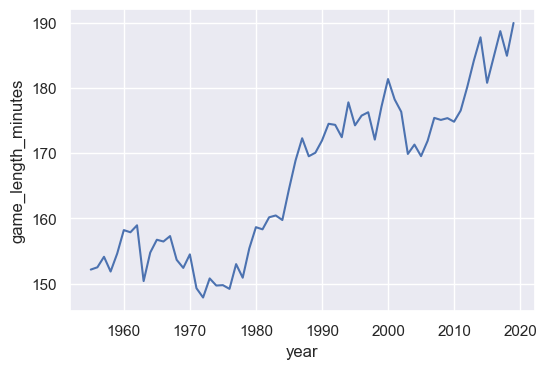

In [13]:
# plot the data
sns.lineplot('year', 'game_length_minutes', data=minutes_per_game);

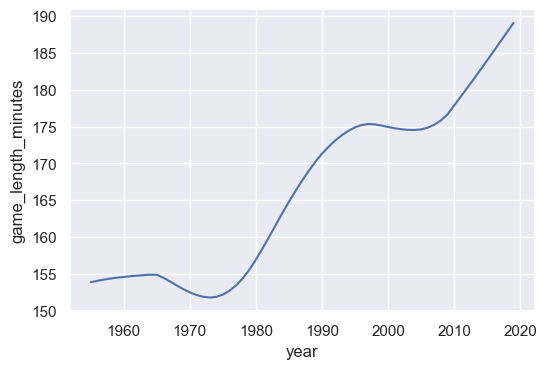

In [14]:
# plot the data, but smooth it first
df = simple_loess('year', 'game_length_minutes', minutes_per_game)
sns.lineplot(x='year', y='game_length_minutes', data=df);

Game length is increasing.  This could be due to more reliance on short relief pitchers. 

# Are Games that use a DH higher scoring?

In [15]:
# find the first year that the dh was used
dh_first = game.loc[game['dh'], 'year'].min()
dh_first

1973

In [16]:
# only consider games from that year on
game_dh = game[game['year'] >= dh_first]

In [17]:
team_game = dh.from_csv_with_types(retrosheet_data / 'team_game.csv.gz')

In [18]:
# join between game and team_game to get the scores
df = pd.merge(team_game[['game_id', 'r']], game_dh[['game_id', 'year', 'dh']], 
              left_on='game_id', right_on='game_id', how='inner')
df.head()

,game_id,r,year,dh
0,ATL197304060,1,1973,False
1,ATL197304060,2,1973,False
2,ATL197304081,3,1973,False
3,ATL197304081,10,1973,False
4,ATL197304082,4,1973,False


In [19]:
dh_games = df[df['dh']]
no_dh_games = df[~df['dh']]

In [20]:
dh_games['r'].mean()

4.626851267939384

In [21]:
no_dh_games['r'].mean()

4.362823898648907

In [22]:
len(dh_games), len(no_dh_games)

(104658, 104508)

In [23]:
delta = dh_games['r'].mean() - no_dh_games['r'].mean()
delta

0.2640273692904769

Given the large number of games, this looks significant.  Run the [Monte Carlo](https://en.wikipedia.org/wiki/Resampling_(statistics)#Monte_Carlo_testing) version of the [permutation](https://en.wikipedia.org/wiki/Resampling_(statistics)#Permutation_tests) test to see how likely this large of a difference is.

In [24]:
x = dh_games['r'].values
y = no_dh_games['r'].values

In [25]:
def perm_test(x, y):
    pooled = np.hstack([x, y])
    np.random.shuffle(pooled)
    x_sample = pooled[:len(x)]
    y_sample = pooled[len(x):]
    return x_sample.mean() - y_sample.mean()

In [26]:
np.random.seed(100)
N = 1000
result_array = np.empty(N)
for i in range(N):
    result_array[i] = perm_test(x,y)

In [27]:
result_array.min(), result_array.max()

(-0.03885183947546089, 0.03976518459555578)

In [28]:
(result_array >= delta).mean()

0.0

The observed difference of 0.264 is many times larger than the largest difference observed by chance in 1000 tries.

The use of the Designated Hitter does increase the score.